In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras import backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/randomspace/.local/lib/python3.6/site-packag

In [2]:
print(backend.tensorflow_backend._get_available_gpus())

W0830 15:34:12.959065 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 15:34:12.960769 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0830 15:34:12.961733 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0830 15:34:13.254371 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_va

['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
df_full = pd.read_csv('Consumer_Complaints.csv')
df = df_full.dropna(subset = ["Consumer complaint narrative"])[["Product", "Consumer complaint narrative"]]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231441 entries, 0 to 231440
Data columns (total 2 columns):
Product                         231441 non-null object
Consumer complaint narrative    231441 non-null object
dtypes: object(2)
memory usage: 3.5+ MB


In [4]:
df.Product.value_counts()

Debt collection                                                                 53600
Mortgage                                                                        39452
Credit reporting                                                                31592
Credit reporting, credit repair services, or other personal consumer reports    29805
Credit card                                                                     18842
Bank account or service                                                         14888
Student loan                                                                    14687
Consumer Loan                                                                    9472
Credit card or prepaid card                                                      6197
Checking or savings account                                                      3836
Payday loan                                                                      1748
Vehicle loan or lease                                 

In [5]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

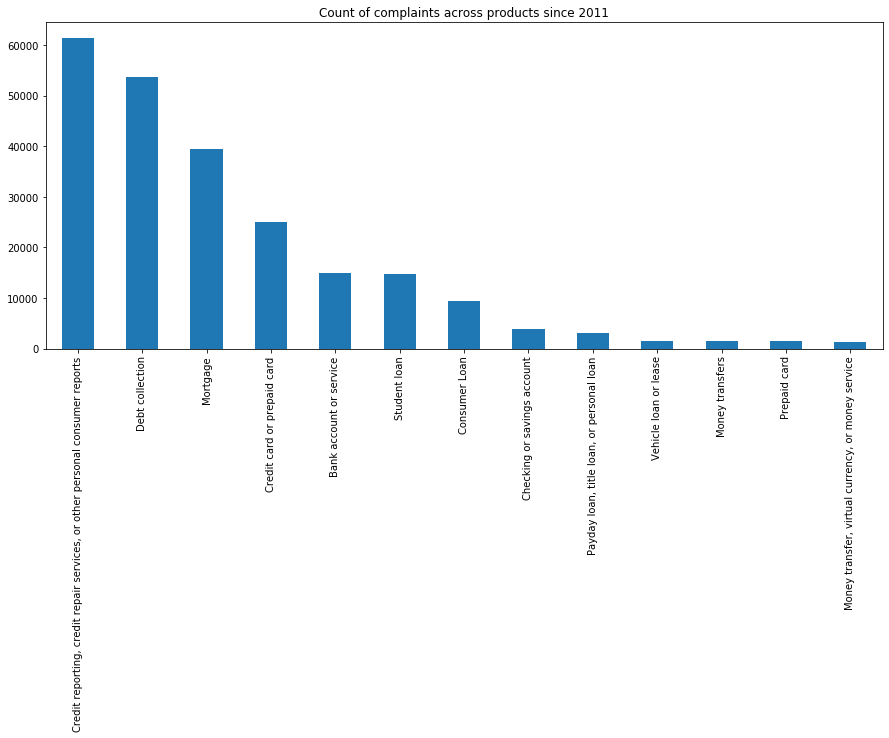

In [6]:
df["Product"].value_counts().plot(x='Product', y='Number of complaints', kind='bar', figsize=(15,6),\
                                  title='Count of complaints across products since 2011')

In [7]:
def print_plot(index):
    example = df[df.index == index][["Product", "Consumer complaint narrative"]].values[0]
    if len(example) > 0:
        print(example[1])
        print('Product:', example[0])

In [8]:
print_plot(10)

Without provocation, I received notice that my credit line was being decreased by nearly 100 %. My available credit was reduced from $ XXXX to XXXX ( the rough amount of my available balance ). 

When I called to question the change, I was provided a nob-descript response referencing my XXXX report. It was my understanding that under the FCRA I was entitled to a copy of this report, but was refused by Citi and have been given no further explanation. 

This is predatory in that it affects my utilization of credit, further subjecting me to increase in APrs, etc and a higher cost of credit without any reason.
Product: Credit card or prepaid card


In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. 
                                              # substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. 
                                        # substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [10]:
print_plot(10)

without provocation received notice credit line decreased nearly  available credit reduced rough amount available balance called question change provided nobdescript response referencing report understanding fcra entitled copy report refused citi given eplanation predatory affects utilization credit subjecting increase aprs etc higher cost credit without reason
Product: Credit card or prepaid card


In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 400

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108892 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (231148, 250)


In [18]:
print(X[10])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [21]:
print(word_index["received"])

12


In [22]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (231148, 13)


In [23]:
print(Y[10])

[0 0 0 1 0 0 0 0 0 0 0 0 0]


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(208033, 250) (208033, 13)
(23115, 250) (23115, 13)


In [25]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(400, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(400))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

W0830 17:05:25.606060 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 17:05:25.633524 140585061427008 deprecation.py:506] From /home/randomspace/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0830 17:05:26.966515 140585061427008 deprecation_wrapper.py:119] From /home/randomspace/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 400)          20000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 400)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 400)          1281600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 400)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                5213      
Total para

In [26]:
epochs = 5
batch_size = 64

history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

W0830 17:09:46.391545 140585061427008 deprecation.py:323] From /home/randomspace/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 187229 samples, validate on 20804 samples
Epoch 1/5
187229/187229 [==============================] - 1963s 10ms/step - loss: 1.7067 - acc: 0.4026 - val_loss: 1.2904 - val_acc: 0.5904
Epoch 2/5
187229/187229 [==============================] - 1924s 10ms/step - loss: 1.0995 - acc: 0.6695 - val_loss: 0.8874 - val_acc: 0.7399
Epoch 3/5
187229/187229 [==============================] - 1953s 10ms/step - loss: 0.8395 - acc: 0.7599 - val_loss: 0.7168 - val_acc: 0.7889
Epoch 4/5
187229/187229 [==============================] - 1950s 10ms/step - loss: 0.7038 - acc: 0.7969 - val_loss: 0.6519 - val_acc: 0.8039
Epoch 5/5
187229/187229 [==============================] - 1962s 10ms/step - loss: 0.6441 - acc: 0.8126 - val_loss: 0.6421 - val_acc: 0.8072


In [27]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model.save(os.path.join(model_dir, 'LSTM.h5'))

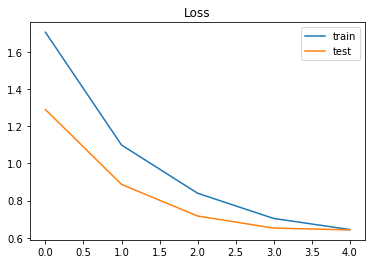

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

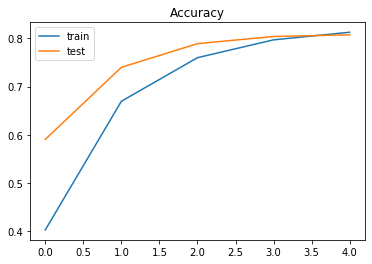

In [29]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [30]:
model = load_model(os.path.join(model_dir, 'LSTM.h5'))

In [31]:
predictions = model.predict(X_test)

In [32]:
classes = pd.get_dummies(df["Product"]).columns.values
matrix = confusion_matrix(Y_test.argmax(axis = 1), predictions.argmax(axis = 1))
report = classification_report(Y_test.argmax(axis = 1), predictions.argmax(axis = 1), target_names = classes)

/home/randomspace/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
print(matrix)
print(report)

[[1099    0   37  188   17   77    0    0   69    0    0    9    0]
 [ 322    0    4   43    4   25    0    0    6    1    0    3    0]
 [  17    0  601   37   79  179    0    0   26    5    0   33    0]
 [  93    0   40 1872  132  269    0    0   10    0    0   12    0]
 [  14    0   77  137 5134  598    0    0  107    0    0   74    0]
 [   8    0   75   70  203 4874    0    0   84    3    0   71    0]
 [ 119    0    3   18    7   11    0    0    2    0    0    2    0]
 [  98    0    2   13    0    9    0    0    2    1    0    0    0]
 [  31    0   60    3   51  111    0    0 3676    2    0    8    0]
 [   9    0  125    5   11  138    0    0    9   12    0   13    0]
 [  33    0    0   95    2    2    0    0    1    0    0    0    0]
 [   4    0   28    1   25   69    0    0    6    0    0 1308    0]
 [   1    0  116    2   11   13    0    0    2    4    0    3    0]]
                                                                              precision    recall  f1-score   suppo